## Change Detector in 4D tomography  

The goal of this notebook to build and test a "change detector" that returns coordinates of ROI(s) inside a 3D volume where morphology changes w.r.t the previous 3D image. To measure this change, a sub-volume (or patch) at time-step = t and the same patch from time-step = t-1 is passed through a latent feature extractor, then the eucledian distance between the latent embeddings is computed as the "change metric". An array of this metric computed for different patches is then sorted to find the top 'n' patches that changed. Then this is visualized in a point cloud.  
**Data:** Coal-ice experiment data from Viktor Nikitin (APS 2-BM).  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import sys
from ct_segnet import viewer
# from features3D import FeatureExtractor4D
from tomo_encoders.patches import Patches
import tensorflow as tf
from tomo_encoders.neural_nets.porosity_encoders import build_CAE_3D
sys.path.append('../.')
from recon4D import DataGetter
import time
from features4D import FeatureExtraction4D

**Two reconstructions to compare** at time-steps 0 and 25, where tstep is defined as one full rotation (360).

In [2]:
def show_in_volume(vols, p_sel, seld_idx):
    point = p_sel.points[sel_idx]
    center = p_sel.centers()[sel_idx]
    for tstep in [0,1]:
        fig, ax = plt.subplots(1,3, figsize = (14,5))
        ax[0].imshow(vols[tstep][point[0],...], cmap = 'gray')
        ax[0].scatter([center[2]],[center[1]])
        ax[1].imshow(vols[tstep][:,point[1],:], cmap = 'gray')
        ax[1].scatter([center[2]],[center[0]])
        ax[2].imshow(vols[tstep][:,:,point[2]], cmap = 'gray')
        ax[2].scatter([center[1]],[center[0]])    
        
def show_before_after(vols, p_sel, sel_idx):
    sz, sy, sx = p_sel.slices()[sel_idx]
    fig, ax = plt.subplots(1,3, figsize = (8,2*len(p_sel.points)))
    viewer.view_midplanes(vols[0][sz,sy,sx], ax = ax)
    ax[0].text(-64,48, "before", fontsize = 20, rotation = "vertical")
    fig.tight_layout()
    fig, ax = plt.subplots(1,3, figsize = (8,2*len(p_sel.points)))
    viewer.view_midplanes(vols[1][sz,sy,sx], ax = ax)    
    ax[0].text(-64,48, "after", fontsize = 20, rotation = "vertical")
    fig.tight_layout()
    return

In [3]:
# Reconstruction stuff
fnames = ['/data02/MyArchive/coalice/melting_086.h5', \
          '/data02/MyArchive/coalice/flat_fields_melting_086.h5', \
          '/data02/MyArchive/coalice/dark_fields_melting_086.h5']
ntheta = 361 # these many projections per 180 degree spin
recon_params = {"mask_ratio" : None, \
                "contrast_s" : 0.01}

In [4]:
idxs = [0, 720*25]
dget = DataGetter(*fnames, ntheta)
vols = [dget.reconstruct_window(idx,dget.find_center(idx), **recon_params) for idx in idxs]
# fig, ax = plt.subplots(1,3, figsize = (14,6))
# viewer.view_midplanes(vol = vol, ax = ax)   

Shape of projection image: (1, 600, 960)
center = 471.00
center = 471.00


In [5]:
bin_tag = 'bin1'
bin_size = (64,64,64)
model_names = {"CAE" : "CAE_111d128_coal-ice-tzero-%s"%bin_tag, \
               "latent_embedder" : "latent_embedder_111d128_coal-ice-tzero-%s"%bin_tag}
model_path = '/data02/MyArchive/aisteer_3Dencoders/models/coalice'

fe = FeatureExtraction4D(vols[0].shape, \
                         model_initialization = 'load-model', \
                         model_names = model_names, model_path = model_path)

In [6]:
vols = [fe._normalize_volume(vol) for vol in vols]

total time for change detector = 21.99 seconds


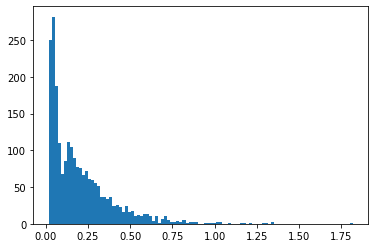

In [7]:
t0 = time.time()
p = Patches(vols[0].shape, initialize_by = "grid", patch_size = bin_size)
sub_vols_prev = p.extract(vols[0], fe.model_size)
sub_vols_curr = p.extract(vols[1], fe.model_size)

h_prev = fe.models["latent_embedder"].predict(sub_vols_prev[...,np.newaxis])
h_curr = fe.models["latent_embedder"].predict(sub_vols_curr[...,np.newaxis])
h_delta = (h_curr - h_prev)**2
h_delta = np.mean(h_delta, axis = 1)
h_delta = np.sqrt(h_delta)
p.add_features(h_delta.reshape(-1,1), names = ["h_delta"])
t1 = time.time()
tot_time_fe = t1 - t0
print("total time for change detector = %.2f seconds"%tot_time_fe)
mse = np.mean(np.power(sub_vols_curr - sub_vols_prev, 2), axis = (1,2,3))
p.add_features(mse.reshape(-1,1), names = ["mse"])
h = plt.hist(p.features[:,0], bins = 100)

In [8]:
p_sel = p.select_by_feature(10, ife = 0, selection_by = "highest")
p_sel.features

array([[1.8197813 , 0.0521769 ],
       [1.3427305 , 0.04829864],
       [1.3360779 , 0.07142681],
       [1.3129376 , 0.03896932],
       [1.2916119 , 0.04280676],
       [1.2121519 , 0.0429267 ],
       [1.186382  , 0.04608737],
       [1.1632293 , 0.06519967],
       [1.0835896 , 0.05154245],
       [1.0439986 , 0.06195049]], dtype=float32)

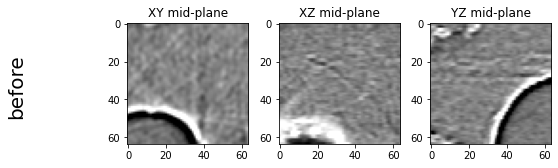

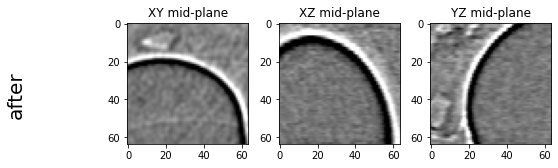

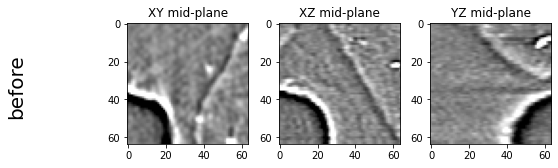

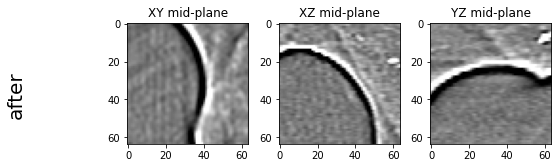

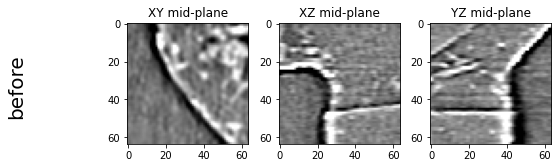

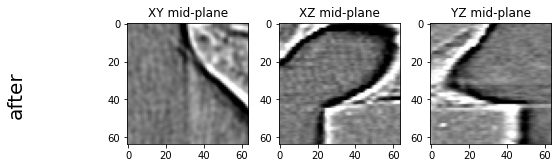

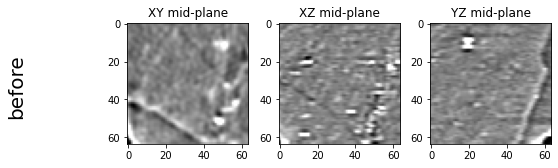

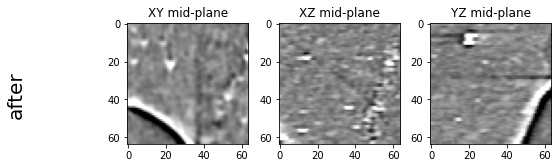

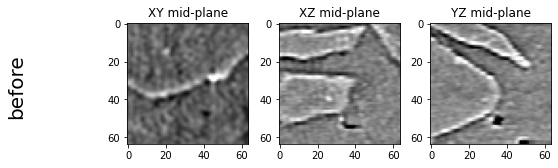

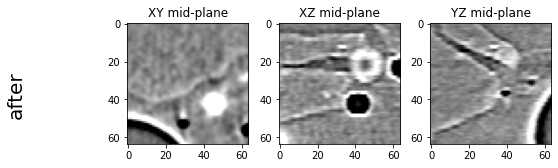

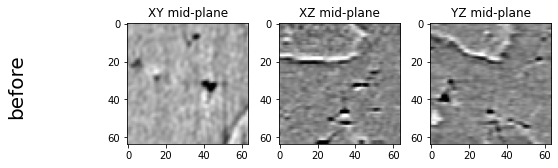

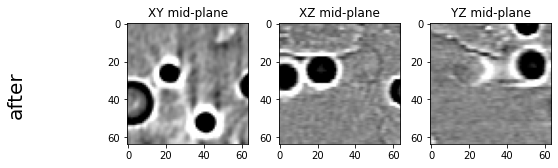

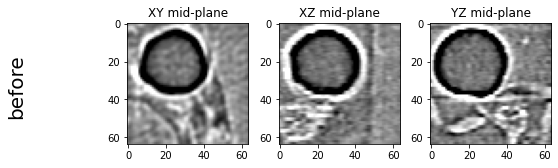

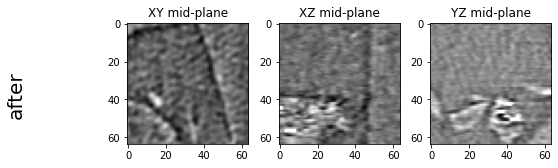

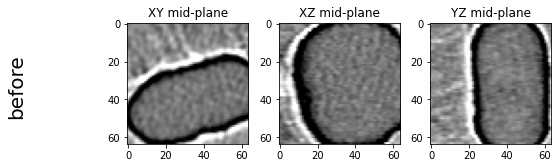

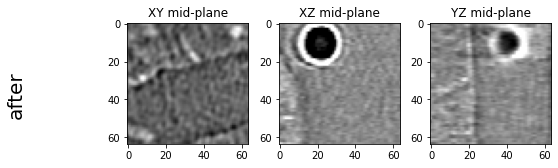

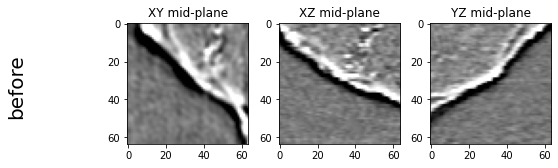

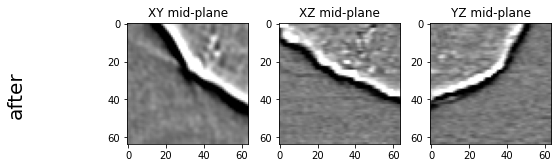

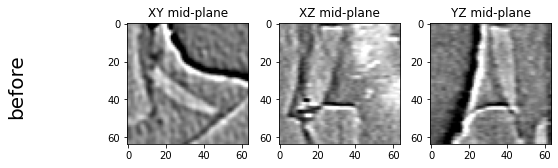

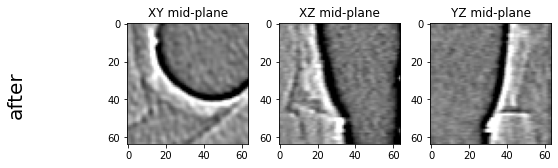

In [9]:
for ii in range(10):
    show_before_after(vols, p_sel, ii)

In [10]:
p_sel = p.select_by_feature(10, ife = 0, selection_by = "lowest")

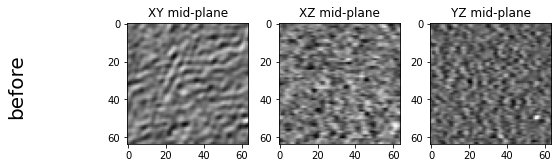

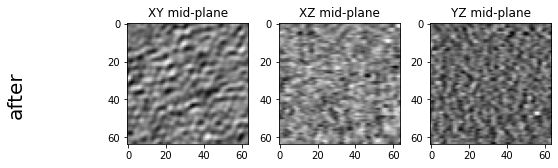

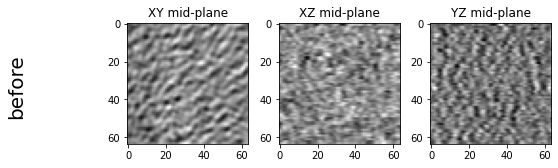

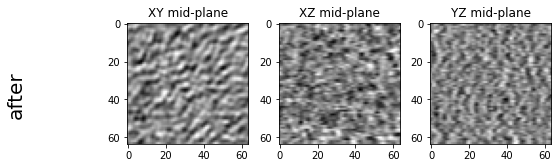

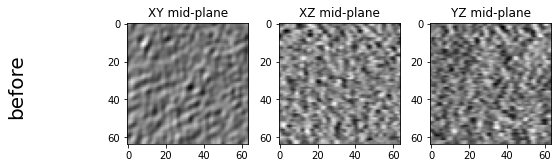

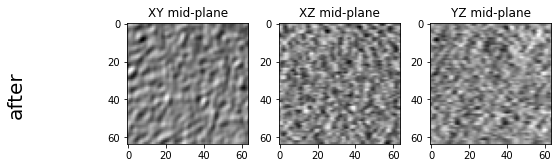

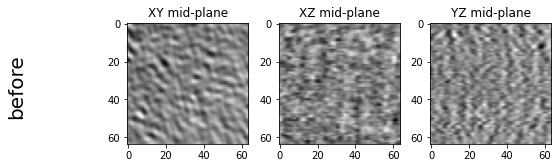

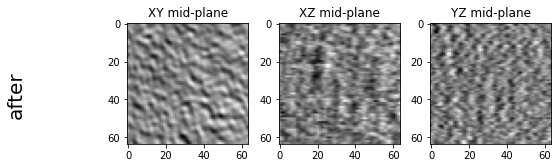

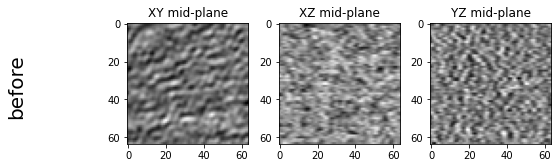

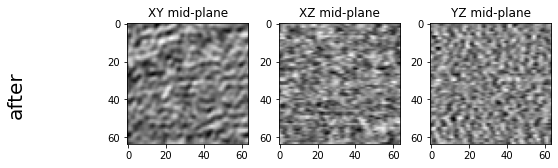

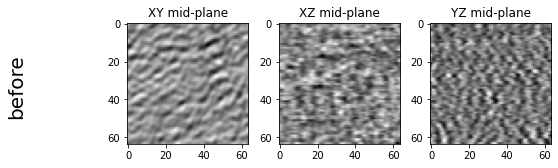

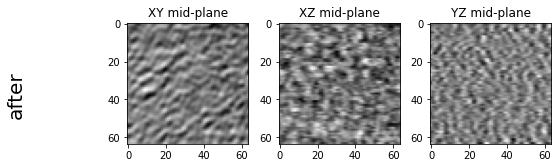

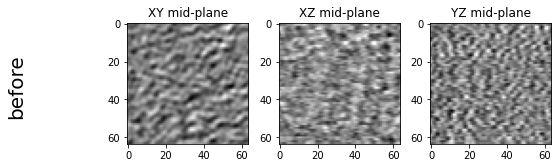

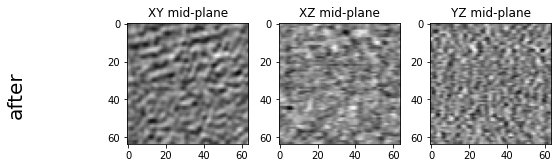

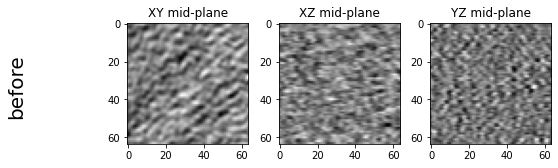

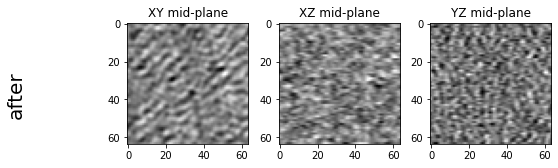

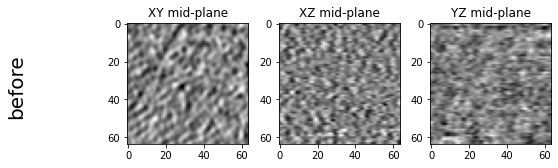

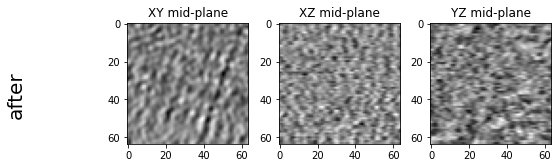

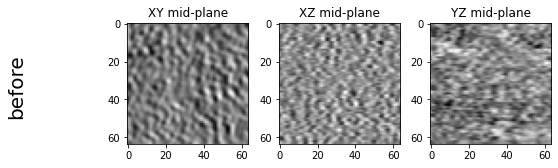

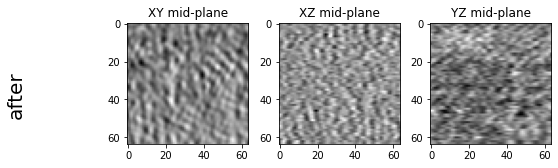

In [11]:
for ii in range(10):
    show_before_after(vols, p_sel, ii)

In [12]:
# show_in_volume(vols, p_sel)

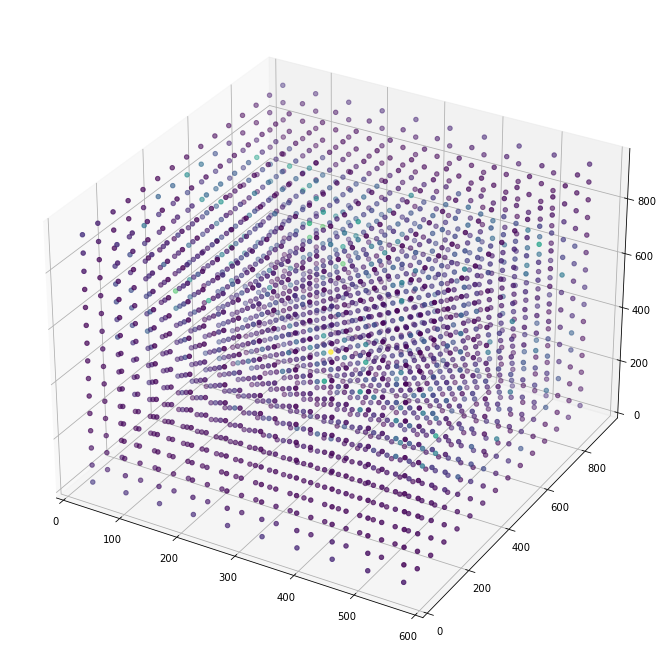

In [13]:
fig = plt.figure(figsize = (12,12))
p.plot_3D_feature(0,fig)

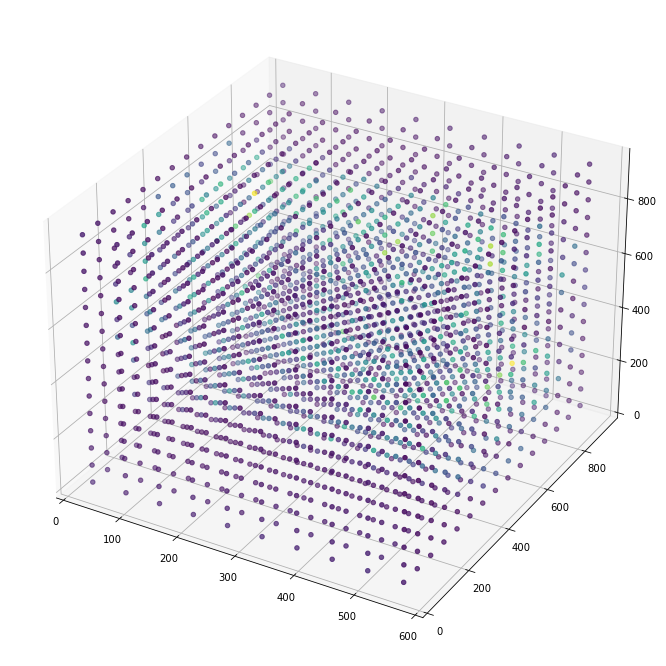

In [14]:
fig = plt.figure(figsize = (12,12))
p.plot_3D_feature(1,fig)

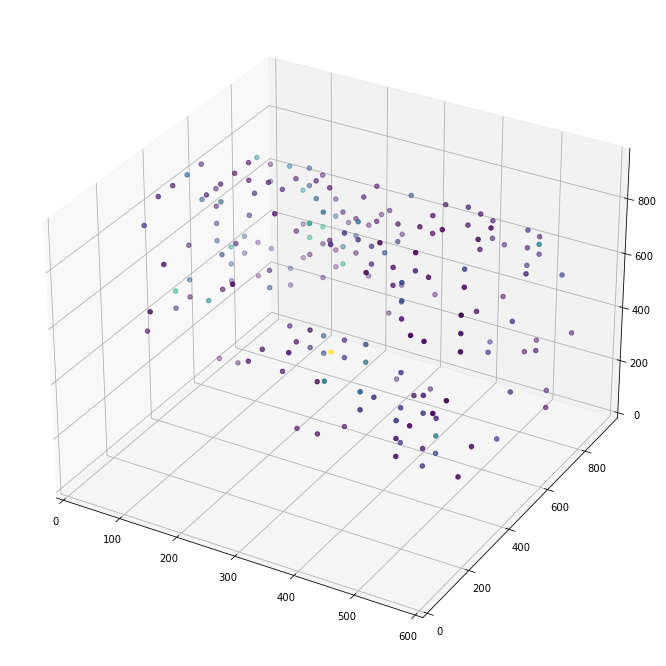

In [15]:
p_sel = p.select_by_feature(200, ife = 0, selection_by = "highest")
fig = plt.figure(figsize = (12,12))
p_sel.plot_3D_feature(0,fig)

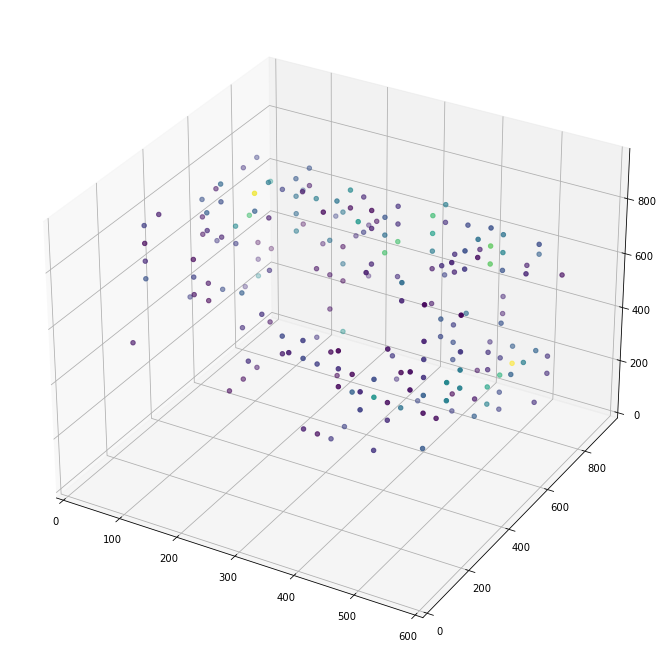

In [16]:
p_sel = p.select_by_feature(200, ife = 1, selection_by = "highest")
fig = plt.figure(figsize = (12,12))
p_sel.plot_3D_feature(1,fig)